<a href="https://colab.research.google.com/github/ekerintaiwoa/MediaApp/blob/master/kids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import random
from PIL import Image, ImageDraw, ImageFont

# Settings
categories = ['adult', 'kids']
output_dir = 'book_dataset'
samples_per_class = 50
image_size = (224, 300)
# Using a font known to be available in Colab environment
fonts = ["/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"]

# Words for content
adult_titles = ["Desire", "Thriller", "Secrets", "Dark", "Obsession"]
kids_titles = ["Adventures", "Fairy Tale", "Magic", "Puppy", "Rainbow"]

def create_book_cover(title, color):
    img = Image.new('RGB', image_size, color=color)
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype(random.choice(fonts), size=24)
    except IOError:
        # Fallback to a default PIL font if truetype font fails
        font = ImageFont.load_default()
    # Use textbbox instead of textsize for newer Pillow versions
    bbox = draw.textbbox((0, 0), title, font=font)
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    draw.text(((image_size[0]-w)/2, (image_size[1]-h)/2), title, font=font, fill="white")
    return img

# Generate images
for phase in ['train', 'val']:
    for category in categories:
        path = os.path.join(output_dir, phase, category)
        os.makedirs(path, exist_ok=True)
        for i in range(samples_per_class if phase == 'train' else samples_per_class // 2):
            title = random.choice(adult_titles if category == 'adult' else kids_titles)
            color = (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))
            img = create_book_cover(title, color)
            img.save(os.path.join(path, f"{category}_{i}.jpg"))

In [4]:
import os
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import random
import time

# Settings
dataset_dir = "book_datasetees"
categories = {
    "kids": ["fairy tale", "children", "magic adventure", "puppy", "bedtime story"],
    "adult": ["thriller", "dark romance", "horror", "crime mystery", "adult fiction"]
}
books_per_category = 50

def create_folders():
    for phase in ["train", "val"]:
        for category in categories:
            os.makedirs(os.path.join(dataset_dir, phase, category), exist_ok=True)

def fetch_books(query, max_books):
    url = "https://openlibrary.org/search.json"
    params = {"q": query, "has_fulltext": "true", "limit": 100}
    response = requests.get(url, params=params)
    books = response.json().get("docs", [])
    return books[:max_books]

def download_cover(cover_id, save_path):
    img_url = f"https://covers.openlibrary.org/b/id/{cover_id}-L.jpg"
    try:
        response = requests.get(img_url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 300))
        img.save(save_path)
        return True
    except Exception:
        return False

def download_category(category, keywords, split_ratio=0.7):
    all_images = []
    for keyword in keywords:
        books = fetch_books(keyword, books_per_category)
        for book in books:
            if "cover_i" in book:
                all_images.append(book["cover_i"])
            if len(all_images) >= books_per_category:
                break
        if len(all_images) >= books_per_category:
            break

    random.shuffle(all_images)
    split_index = int(len(all_images) * split_ratio)
    train_ids = all_images[:split_index]
    val_ids = all_images[split_index:]

    for i, cid in enumerate(tqdm(train_ids, desc=f"Downloading {category} train")):
        save_path = os.path.join(dataset_dir, "train", category, f"{category}_{i}.jpg")
        download_cover(cid, save_path)
        time.sleep(0.1)  # polite delay

    for i, cid in enumerate(tqdm(val_ids, desc=f"Downloading {category} val")):
        save_path = os.path.join(dataset_dir, "val", category, f"{category}_{i}.jpg")
        download_cover(cid, save_path)
        time.sleep(0.1)

# Main script
if __name__ == "__main__":
    create_folders()
    for category, keywords in categories.items():
        download_category(category, keywords)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

# Set path
data_dir = "book_dataset"
img_size = (224, 224)
batch_size = 32


In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get class names before prefetching
class_names = train_ds.class_names

# Improve performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 100 files belonging to 2 classes.
Found 50 files belonging to 2 classes.


In [13]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  # 2 classes: adult, kids
])


In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4691 - loss: 1.0835 - val_accuracy: 0.5200 - val_loss: 0.8162
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4938 - loss: 0.9285 - val_accuracy: 0.5000 - val_loss: 0.9209
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5266 - loss: 0.9425 - val_accuracy: 0.4000 - val_loss: 0.7208
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5149 - loss: 0.8020 - val_accuracy: 0.5000 - val_loss: 0.8830
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5207 - loss: 0.8284 - val_accuracy: 0.5200 - val_loss: 0.7578
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5172 - loss: 0.8286 - val_accuracy: 0.4400 - val_loss: 0.7064
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4555 - loss: 0.8595 - val_accuracy: 0.5200 - val_loss: 0.7201
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4884 - loss: 0.8757 - val_accuracy: 0.5200 - val_loss: 0.7214
Epoch 9/10
4

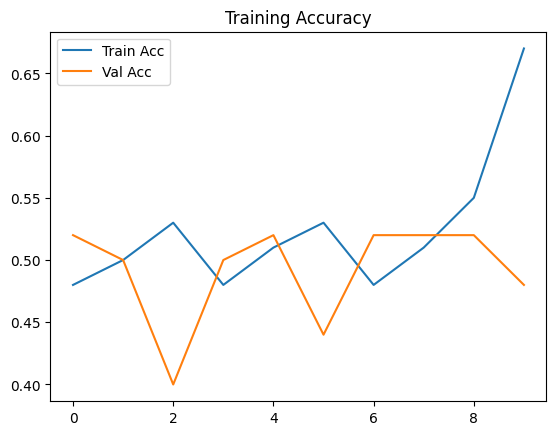

In [16]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training Accuracy')
plt.legend()
plt.show()


In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image

class_names = train_ds.class_names  # ['adult', 'kids']

def predict_book_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions)]
    confidence = 100 * np.max(predictions)
    print(f"Prediction: {pred_class} ({confidence:.2f}%)")


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class: kids (65.16%)


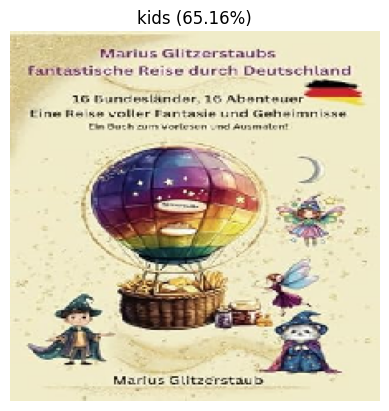

In [27]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- SETTINGS ---
img_path = "/content/sample_data/519huk8ddZL._SY445_SX342_.jpg"  # Replace with your test image
img_size = (224, 224)    # Must match training size
class_names = ['adult', 'kids']  # Adjust if order is different

# --- LOAD MODEL (if saved earlier) ---
# model = tf.keras.models.load_model("book_classifier.h5")  # Uncomment if loading

# --- LOAD AND PREPROCESS IMAGE ---
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

# --- PREDICT ---
predictions = model.predict(img_array)
pred_index = np.argmax(predictions)
pred_class = class_names[pred_index]
confidence = 100 * np.max(predictions)

# --- DISPLAY RESULT ---
print(f"Predicted class: {pred_class} ({confidence:.2f}%)")

# Optional: Show image with prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"{pred_class} ({confidence:.2f}%)")
plt.show()


In [28]:
# prompt: create a  streamlit app to test the model

!pip install streamlit

import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf

# Assuming your trained model and class_names are available from the previous code
# If you are running this as a standalone script, you need to load your model
# and define class_names here.

# Example: Load the saved model and define class names
# model = tf.keras.models.load_model("book_classifier.h5") # If you saved it
# class_names = ['adult', 'kids'] # Make sure this matches your training data

# Check if model and class_names exist from the previous cell's execution
# If running as a standalone script, remove this check and load them explicitly.
if 'model' not in locals() or 'class_names' not in locals():
    st.error("Model or class_names not found. Please train the model first or load a saved model.")
    st.stop() # Stop the script if model is not available

img_size = (224, 224) # Must match training size

st.title("Book Cover Classifier")

uploaded_file = st.file_uploader("Upload a book cover image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    try:
        img = Image.open(uploaded_file).convert('RGB')
        st.image(img, caption="Uploaded Image", use_column_width=True)

        # Preprocess the image
        img_resized = img.resize(img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
        img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

        # Make prediction
        predictions = model.predict(img_array)
        pred_index = np.argmax(predictions)
        pred_class = class_names[pred_index]
        confidence = 100 * np.max(predictions)

        st.subheader("Prediction:")
        st.write(f"Predicted class: **{pred_class}**")
        st.write(f"Confidence: **{confidence:.2f}%**")

    except Exception as e:
        st.error(f"Error processing image: {e}")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


2025-06-14 12:18:43.853 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-14 12:18:43.995 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-14 12:18:43.996 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-14 12:18:43.999 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-14 12:18:44.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-14 12:18:44.003 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-14 12:18:44.005 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-14 12:18:44.009 Thread 'MainThread': mi

In [ ]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.210.204:8501

